In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras import backend as K
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Reading the dataset
df = pd.read_csv("ITC.BO.csv", parse_dates=['Date'], index_col='Date')

In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-04-01,88.183296,88.966698,87.683296,88.116699,64.755638,357804.0
2010-04-05,88.449997,89.333298,87.783302,88.016701,64.682159,516297.0
2010-04-06,88.333298,88.933296,87.766701,88.666702,65.159821,800808.0
2010-04-07,89.233299,90.066704,87.833298,89.816704,66.004944,1586418.0
2010-04-08,89.516701,89.666702,88.550003,89.216698,65.564018,804597.0
...,...,...,...,...,...,...
2020-03-25,150.000000,151.899994,139.000000,147.350006,140.137070,1686218.0
2020-03-26,150.000000,162.050003,143.300003,157.199997,149.504898,1871263.0
2020-03-27,160.100006,166.000000,154.949997,162.899994,154.925873,1619672.0


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2465.000000,2465.000000,2465.000000,2465.000000,2465.000000,2.465000e+03
mean,214.624792,216.647875,212.063825,214.279588,187.148220,8.308597e+05
std,58.515179,58.919448,57.942803,58.302119,60.338567,9.340486e+05
min,85.666702,86.966698,84.616699,86.316704,63.432842,0.000000e+00
25%,175.733002,177.432999,173.466995,175.699997,144.584808,3.875560e+05
50%,225.100006,227.500000,222.600006,224.899994,191.043533,5.683060e+05
75%,260.000000,262.549988,257.399994,259.450012,237.336273,9.266800e+05
max,345.250000,353.200012,340.299988,342.299988,313.426666,1.312159e+07


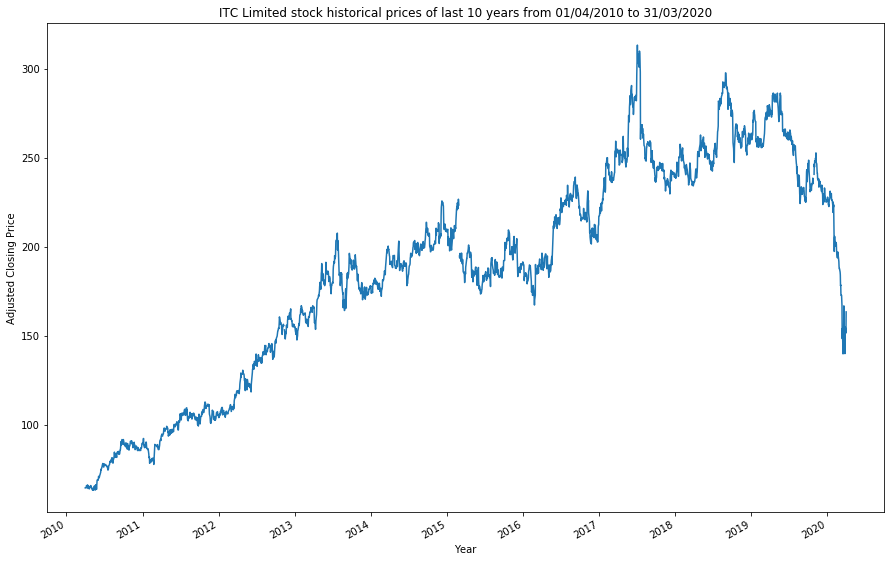

In [5]:
# Plotting the target data
plt.figure(figsize=(15,10))
ax = df['Adj Close'].plot()
ax.set_xlabel("Year")
ax.set_ylabel("Adjusted Closing Price")
plt.title("ITC Limited stock historical prices of last 10 years from 01/04/2010 to 31/03/2020")
plt.show()

In [6]:
# Checking if any NA values are there in dataset
df.isnull().sum()

Open         7
High         7
Low          7
Close        7
Adj Close    7
Volume       7
dtype: int64

In [7]:
# Imputing NA values with mean of dataset month-wise
df = df.fillna(df.groupby(df.index.month).transform('mean'))
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
# Calculating monthly moving average of data
df['MA_30'] = df['Adj Close'].rolling(30).mean()
df['MA_30']

Date
2010-04-01           NaN
2010-04-05           NaN
2010-04-06           NaN
2010-04-07           NaN
2010-04-08           NaN
                 ...    
2020-03-25    175.148348
2020-03-26    173.388907
2020-03-27    171.800656
2020-03-30    170.137905
2020-03-31    169.004572
Name: MA_30, Length: 2472, dtype: float64

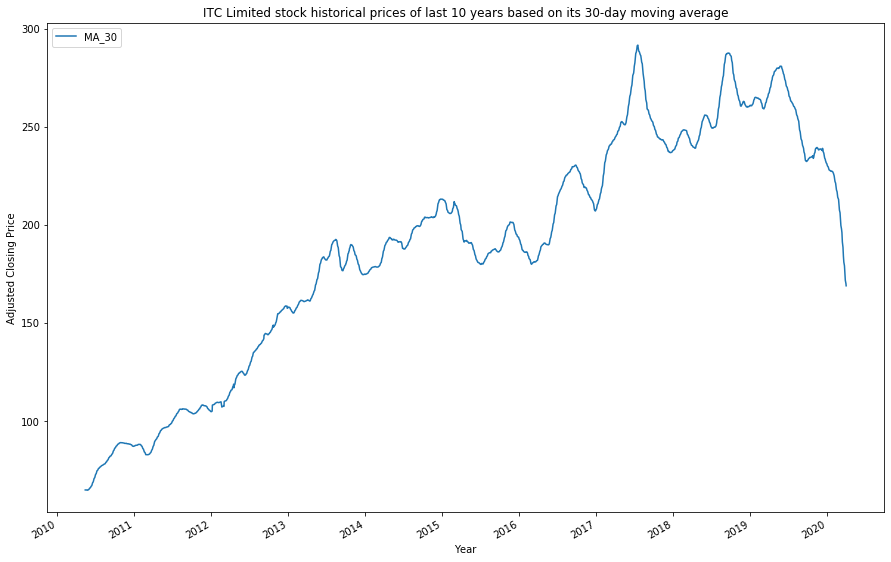

In [9]:
# Plotting the moving average of target data
plt.figure(figsize=(15,10))
ax = df['MA_30'].plot()
ax.set_xlabel("Year")
ax.set_ylabel("Adjusted Closing Price")
plt.legend(loc=2)
plt.title("ITC Limited stock historical prices of last 10 years based on its 30-day moving average")
plt.show()

In [10]:
# Creating the target variable
X = df.iloc[:,[4]].values
X

array([[ 64.755638],
       [ 64.682159],
       [ 65.159821],
       ...,
       [154.925873],
       [151.692307],
       [163.580429]])

In [11]:
# Feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

In [12]:
# Creating a data structure with 30 timesteps and 1 output
X_train = []
y_train = []
for i in range(30, X.shape[0]):
    X_train.append(X[i-30:i, 0])
    y_train.append(X[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
X_train.shape

(2442, 30)

In [14]:
# Reshaping for LSTM 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [15]:
X_train.shape

(2442, 30, 1)

In [16]:
# Defining custom loss function, i.e., root mean squared error
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred-y_true)))

In [17]:
# Setting Adam optimizer with learning rate of 0.001
adam = Adam(lr = 0.001)

In [18]:
# Model
model = Sequential()
model.add(LSTM(100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

In [19]:
# Running the model
model.compile(optimizer = adam, loss = rmse)
model.fit(X_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.1)

Train on 2197 samples, validate on 245 samples
Epoch 1/100
2197/2197 [==============================] - 5s 2ms/step - loss: 0.1559 - val_loss: 0.0995
Epoch 2/100
2197/2197 [==============================] - 4s 2ms/step - loss: 0.0563 - val_loss: 0.0471
Epoch 3/100
2197/2197 [==============================] - 4s 2ms/step - loss: 0.0438 - val_loss: 0.0426
Epoch 4/100
2197/2197 [==============================] - 4s 2ms/step - loss: 0.0402 - val_loss: 0.0488
Epoch 5/100
2197/2197 [==============================] - 4s 2ms/step - loss: 0.0413 - val_loss: 0.0662
Epoch 6/100
2197/2197 [==============================] - 4s 2ms/step - loss: 0.0444 - val_loss: 0.0418
Epoch 7/100
2197/2197 [==============================] - 4s 2ms/step - loss: 0.0403 - val_loss: 0.0384
Epoch 8/100
2197/2197 [==============================] - 4s 2ms/step - loss: 0.0395 - val_loss: 0.0372
Epoch 9/100
2197/2197 [==============================] - 4s 2ms/step - loss: 0.0383 - val_loss: 0.0553
Epoch 10/100
2197/2197 [==

2197/2197 [==============================] - 4s 2ms/step - loss: 0.0278 - val_loss: 0.0259
Epoch 80/100
2197/2197 [==============================] - 4s 2ms/step - loss: 0.0270 - val_loss: 0.0242
Epoch 81/100
2197/2197 [==============================] - 4s 2ms/step - loss: 0.0280 - val_loss: 0.0261
Epoch 82/100
2197/2197 [==============================] - 4s 2ms/step - loss: 0.0271 - val_loss: 0.0246
Epoch 83/100
2197/2197 [==============================] - 4s 2ms/step - loss: 0.0261 - val_loss: 0.0257
Epoch 84/100
2197/2197 [==============================] - 4s 2ms/step - loss: 0.0266 - val_loss: 0.0260
Epoch 85/100
2197/2197 [==============================] - 5s 2ms/step - loss: 0.0272 - val_loss: 0.0244
Epoch 86/100
2197/2197 [==============================] - 4s 2ms/step - loss: 0.0260 - val_loss: 0.0262
Epoch 87/100
2197/2197 [==============================] - 4s 2ms/step - loss: 0.0265 - val_loss: 0.0271
Epoch 88/100
2197/2197 [==============================] - 4s 2ms/step - loss:

In [20]:
# Reading test data
test = pd.read_csv("ITC.BO (1).csv", parse_dates=['Date'], index_col='Date')
y = test.iloc[:, [4]].values

In [21]:
# Prediction
data = pd.concat((df['Adj Close'], test['Adj Close']), axis = 0)
inputs = data[len(data) - len(test) - 30:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(30, inputs.shape[0]):
    X_test.append(inputs[i-30:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred = model.predict(X_test)
pred = sc.inverse_transform(pred)

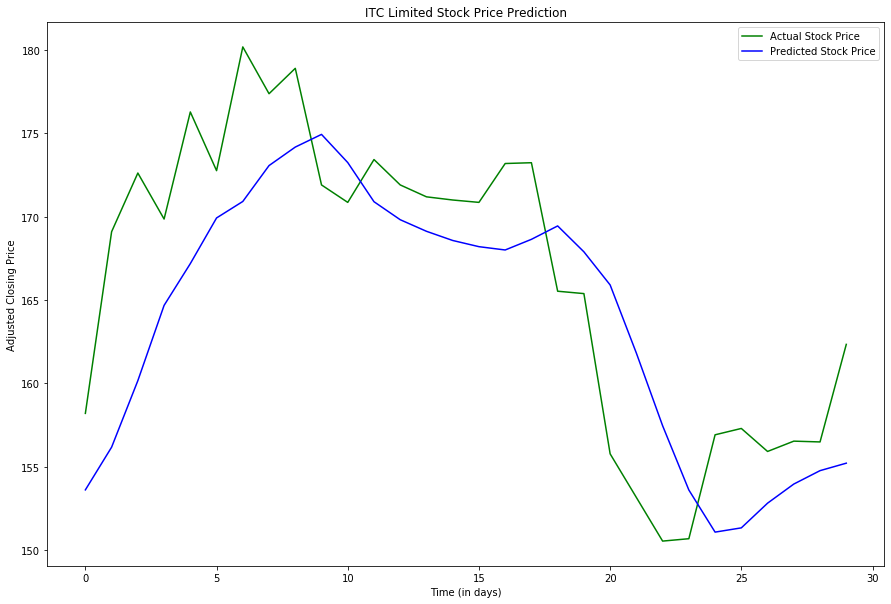

In [22]:
# Results
plt.figure(figsize=(15,10))
plt.plot(y, color = 'green', label = 'Actual Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('ITC Limited Stock Price Prediction')
plt.xlabel('Time (in days)')
plt.ylabel('Adjusted Closing Price')
plt.legend()
plt.show()